# Cyclomatic Complexity Analysis Notebook

This notebook analyzes how cyclomatic complexity metrics relate to overall_score using Spearman rank correlation.


## Imports


In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from scipy.stats import spearmanr

# Enable inline plotting in Jupyter
%matplotlib inline


## Configuration


In [11]:
# Configuration
SUMMARY_GLOB = "../results/summary/*_summary.csv"


## Theme and Color Palette Setup


In [12]:
# Theme
sns.set_theme(style="whitegrid", rc={
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (10, 5.5),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "grid.alpha": 0.25,
})

# Beautiful red → green divergent palette (12 steps)
divergent_cmap = sns.diverging_palette(
    h_neg=355,   # red
    h_pos=130,   # green
    s=90, l=55,
    sep=10,
    n=12,
    center="light"
)

sns.set_palette(divergent_cmap)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=divergent_cmap)


## Utility Functions


In [13]:
def load_summary_files(pattern: str) -> pd.DataFrame:
    """Load all matching CSVs and attach a 'model' column (derived from filename)."""
    files = glob.glob(pattern)
    print(f"Found {len(files)} summary files")
    dfs = []
    for f in files:
        model_name = Path(f).stem.replace("_summary", "")
        try:
            df_temp = pd.read_csv(f)
            df_temp["model"] = model_name
            dfs.append(df_temp)
        except Exception as e:
            print(f"WARNING: failed to read '{f}': {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [14]:
def sanitize_series(s: pd.Series) -> pd.Series:
    """Attempt to coerce series to numeric and drop NaNs for plotting."""
    return pd.to_numeric(s, errors="coerce")


## Data Loading


In [15]:
# Load all summary files
df_all = load_summary_files(SUMMARY_GLOB)
print(f"\nLoaded data with {len(df_all)} rows")
df_all.head()


Found 4 summary files

Loaded data with 656 rows


,task_id,passed,avg_cyclomatic_complexity,max_cyclomatic_complexity,style_score,efficiency_score,loc_score,functional_correctness,overall_score,model
0,HumanEval/0,False,NaN,NaN,0.000000,NaN,0.98,0.0,0.000000,codegemma_7b
1,HumanEval/1,False,0.7,0.7,0.538462,NaN,0.72,0.0,0.000000,codegemma_7b
2,HumanEval/2,True,0.1,0.1,0.500000,0.999998,0.96,1.0,0.468069,codegemma_7b
3,HumanEval/3,True,0.3,0.3,0.142857,NaN,0.86,1.0,0.332793,codegemma_7b
4,HumanEval/4,False,NaN,NaN,0.000000,NaN,0.98,0.0,0.000000,codegemma_7b


## Cyclomatic Complexity Analysis

Deep dive into how cyclomatic complexity metrics relate to overall_score using Spearman rank correlation.


CYCLOMATIC COMPLEXITY SPEARMAN CORRELATION ANALYSIS (TASK-LEVEL)

1. TARGET TABLE (Sample - First 20 rows):
--------------------------------------------------------------------------------
Total tasks: 656
Columns: model, task_id, overall_score, avg_cyclomatic_complexity, max_cyclomatic_complexity

Sample data:
       model      task_id  overall_score  avg_cyclomatic_complexity  max_cyclomatic_complexity
codegemma_7b  HumanEval/0       0.000000                        NaN                        NaN
codegemma_7b  HumanEval/1       0.000000                        0.7                        0.7
codegemma_7b  HumanEval/2       0.468069                        0.1                        0.1
codegemma_7b  HumanEval/3       0.332793                        0.3                        0.3
codegemma_7b  HumanEval/4       0.000000                        NaN                        NaN
codegemma_7b  HumanEval/5       0.000000                        0.5                        0.5
codegemma_7b  HumanEva

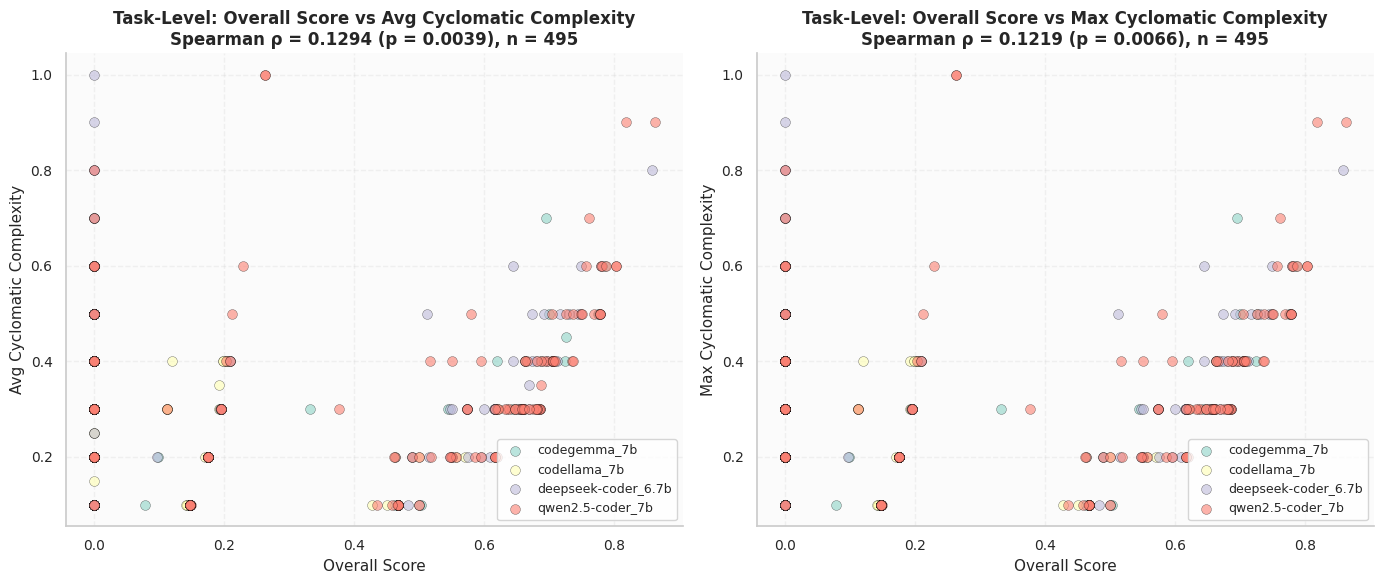


4. SUMMARY STATISTICS BY MODEL:
--------------------------------------------------------------------------------
                    overall_score                 avg_cyclomatic_complexity  \
                            count    mean     std                     count   
model                                                                         
codegemma_7b                  164  0.1295  0.2392                       101   
codellama_7b                  164  0.0764  0.1498                       136   
deepseek-coder_6.7b           164  0.2080  0.2889                       114   
qwen2.5-coder_7b              164  0.3815  0.3005                       144   

                                    max_cyclomatic_complexity                  
                       mean     std                     count    mean     std  
model                                                                          
codegemma_7b         0.2955  0.1503                       101  0.2960  0.1509  
codellama_7b

In [16]:
# Cyclomatic Complexity Spearman Correlation Analysis (Task-Level)

# Load and prepare data
df_clean = df_all.copy()
df_clean["overall_score"] = sanitize_series(df_clean["overall_score"])

# Create task-level target table with model name, task_id, overall_score, and cyclomatic_complexity
cyclomatic_metrics = ["avg_cyclomatic_complexity", "max_cyclomatic_complexity"]
available_cyclomatic = [m for m in cyclomatic_metrics if m in df_clean.columns]

if not available_cyclomatic:
    print("No cyclomatic complexity metrics found in data.")
else:
    # Prepare task-level data
    # Select columns: model, task_id, overall_score, and cyclomatic complexity metrics
    target_cols = ["model", "task_id", "overall_score"] + available_cyclomatic
    task_data = df_clean[target_cols].copy()
    
    # Sanitize cyclomatic complexity metrics
    for metric in available_cyclomatic:
        task_data[metric] = sanitize_series(task_data[metric])
    
    # Drop rows where both overall_score and all cyclomatic metrics are NaN
    # But keep rows where at least one metric is available
    task_data = task_data.dropna(subset=["overall_score"])
    
    print("=" * 80)
    print("CYCLOMATIC COMPLEXITY SPEARMAN CORRELATION ANALYSIS (TASK-LEVEL)")
    print("=" * 80)
    
    # Display sample of target table
    print("\n1. TARGET TABLE (Sample - First 20 rows):")
    print("-" * 80)
    print(f"Total tasks: {len(task_data)}")
    print(f"Columns: {', '.join(target_cols)}")
    print("\nSample data:")
    print(task_data.head(20).to_string(index=False))
    
    # Calculate Spearman correlations at task level
    print("\n2. SPEARMAN RANK CORRELATIONS (Task-Level):")
    print("-" * 80)
    
    # Get valid data (where both overall_score and metric are not NaN)
    overall_scores = task_data["overall_score"].values
    
    for metric in available_cyclomatic:
        # Filter to rows where both overall_score and metric are available
        valid_mask = ~(task_data["overall_score"].isna() | task_data[metric].isna())
        valid_overall = task_data.loc[valid_mask, "overall_score"].values
        valid_metric = task_data.loc[valid_mask, metric].values
        
        if len(valid_overall) < 2:
            print(f"\n{metric}:")
            print(f"  Insufficient data for correlation (n={len(valid_overall)})")
            continue
        
        # Calculate Spearman correlation on task-level data
        corr, p_val = spearmanr(valid_overall, valid_metric)
        
        print(f"\n{metric}:")
        print(f"  Number of tasks: {len(valid_overall)}")
        print(f"  Spearman ρ: {corr:.4f}")
        print(f"  p-value: {p_val:.4f}")
        print(f"  Interpretation: ", end="")
        if corr > 0:
            print("Positive correlation - tasks with higher overall_score tend to have HIGHER complexity")
        else:
            print("Negative correlation - tasks with higher overall_score tend to have LOWER complexity")
    
    # Create visualization
    print("\n3. VISUALIZATIONS (Task-Level):")
    print("-" * 80)
    
    n_metrics = len(available_cyclomatic)
    fig, axes = plt.subplots(1, n_metrics, figsize=(7 * n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]
    
    # Get unique models for coloring
    models = task_data["model"].unique()
    model_palette = sns.color_palette("Set3", n_colors=len(models))
    model_color_map = {m: model_palette[i] for i, m in enumerate(models)}
    
    for idx, metric in enumerate(available_cyclomatic):
        ax = axes[idx]
        
        # Filter to valid data
        valid_mask = ~(task_data["overall_score"].isna() | task_data[metric].isna())
        valid_data = task_data.loc[valid_mask]
        
        if len(valid_data) < 2:
            ax.text(0.5, 0.5, "Insufficient data", 
                   ha="center", va="center", transform=ax.transAxes)
            continue
        
        # Scatter plot of raw values, colored by model
        for model in models:
            model_data = valid_data[valid_data["model"] == model]
            if len(model_data) > 0:
                ax.scatter(model_data["overall_score"], model_data[metric], 
                          s=50, alpha=0.6, edgecolors="black", linewidth=0.3,
                          c=[model_color_map[model]], label=model)
        
        # Calculate and display correlation
        corr, p_val = spearmanr(valid_data["overall_score"], valid_data[metric])
        
        ax.set_xlabel("Overall Score", fontsize=11)
        ax.set_ylabel(f"{metric.replace('_', ' ').title()}", fontsize=11)
        ax.set_title(f"Task-Level: Overall Score vs {metric.replace('_', ' ').title()}\n"
                     f"Spearman ρ = {corr:.4f} (p = {p_val:.4f}), n = {len(valid_data)}",
                     fontsize=12, fontweight="semibold")
        ax.grid(True, alpha=0.25, linestyle="--")
        ax.set_facecolor("#fbfbfb")
        ax.legend(loc="best", fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics by model
    print("\n4. SUMMARY STATISTICS BY MODEL:")
    print("-" * 80)
    summary_stats = task_data.groupby("model").agg({
        "overall_score": ["count", "mean", "std"],
        **{m: ["count", "mean", "std"] for m in available_cyclomatic}
    }).round(4)
    print(summary_stats)
    
    print("\n" + "=" * 80)
    print("Analysis Complete!")
    print("=" * 80)
